# CNN-lytical Assignment-2
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will build a classifier for MNIST from using [PyTorch](https://pytorch.org/docs/stable/index.html). 

*   We will be using the same dataset as the previous assignment for MNIST. **Do not** use the complete MNIST dataset, even though PyTorch makes it really easy.

*   No limitations on your model this time, just don't use CNNs now, that's up next week.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Also remember to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch.

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import pickle
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load *Dataset*
Use the pickle file shared for the previous assignment here.

In [2]:
# mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# load the data set

with open('/content/drive/MyDrive/Colab Notebooks/train_data.pkl','rb') as f:
    data= pickle.load(f)
X = data['X']
y = data['y']


Mounted at /content/drive


**Displaying Images and Pre-Processing** 

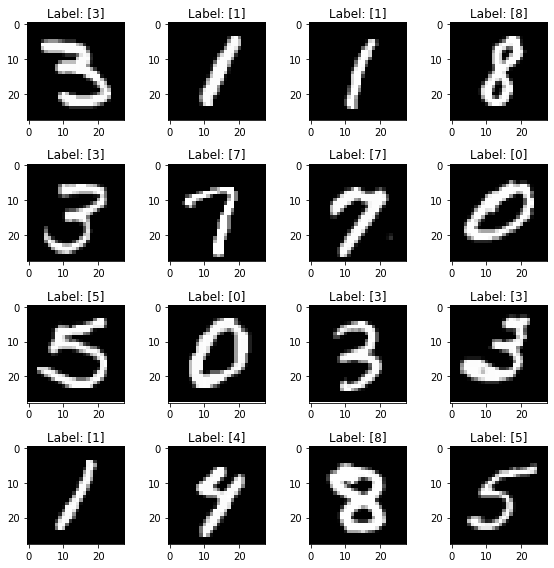

In [3]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels

indices = [random.randrange(0,X.shape[0] - 1) for i in range(16)]
images = np.reshape(X[indices],(16,28,28))
labels = y[indices]
num_row = 4
num_col = 4
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))
for i in range(16):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

# normalize the dataset, won't be doing it here in later assignments

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library

sss = StratifiedShuffleSplit(n_splits=4, test_size=0.15, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


## Creating a Dataset Class
In PyTorch, there is existing implementation of batch-splitting. You don't need to do it manually over here. Instead, just define a Dataset class and a Dataloader wrapping it.

A dataset class must have 3 functions - ```__init__```, ```__len__```, ```__getitem__```. Their names are pretty self-explanatory. You can read more about this [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).


**Note** - Things like normalization, augmentation etc. which are related to the dataset are all done in this class. However, because this assignment doesn't deal with MNIST images but rather feature vectors, this part is being skipped here and will be discussed in Assignment 3.

In [4]:
# define your dataset class
class Image_Dataset(Dataset):
    def __init__(self,X,y):

        '''initializes dataset'''

        self.X = torch.from_numpy(np.array(X, dtype='float32'))
        self.y = torch.from_numpy(np.array(y, dtype='float32'))
        self.n_samples = X.shape[0]

    def __getitem__(self,index):

        '''returns the sample at position (index)'''
        
        return self.X[index],self.y[index]

    def __len__(self):

        '''len(dataset)'''
        return self.n_samples


## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Linear```](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [```nn.ReLU```](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- [```nn.BatchNorm1d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)


In [18]:
# define a child class of nn.Module for your model
# specify the architecture here itself

class Neural_Net(nn.Module):

    def __init__(self,n_x,n_h1,n_h2,n_h3,n_y):

        super(Neural_Net,self).__init__()
        self.l1 = nn.Linear(n_x,n_h1)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(n_h1,n_h2)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(n_h2,n_h3)
        self.a3 = nn.ReLU()
        self.l4 = nn.Linear(n_h3,n_y)
        self.network = nn.Sequential(
            
                        # first hidden layer
                        self.l1,self.a1,

                        nn.BatchNorm1d(n_h1),

                        # second hidden layer
                        self.l2,self.a2,

                        nn.BatchNorm1d(n_h2),
                        
                        # third hidden layer
                        self.l3,self.a3,

                        nn.BatchNorm1d(n_h3),

                        # output layer
                        self.l4
                        
                      )
        
    def forward(self,x):
        output = self.network(x)
        return output

## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [21]:

def train(model, train_loader , optimizer, criterion ,n_epochs, display_step = None):

    n_total_steps = len(train_loader)
    losses=[]
    # enumerate epochs
    for epoch in range(n_epochs + 1):

    # enumerate mini batches
        for i, (images, labels) in enumerate(train_loader):
            #putting images,labels on GPU
            images = images.to(device)
            labels = torch.reshape(labels,(labels.shape[0],))
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            # computing the model output

            outputs = model(images)

            # calculate loss
            loss = criterion(outputs, labels)

            # backward prop, updating, and clearing gradients

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            # printing loss
            if i == n_total_steps-1 and epoch % (n_epochs//10) == 0:
                loss_ = loss.cpu()
                losses.append(loss_.detach().float())
                print (f'Epoch [{epoch}/{n_epochs}], Loss: {loss.item():.4f}') 
        
    plt.plot(losses)
    plt.ylabel('Loss')
    plt.xlabel('epochs (per '+str(n_epochs/10)+' )')
    plt.title("Learning rate = " + str(0.01))
    plt.show()

## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [7]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)
        layer.bias.data.fill_(0.01)

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [25]:
def predict(model, X_test):
    X_test = torch.from_numpy(X_test).to(torch.float32)
    X_test = X_test.to(device)
    outputs = model(X_test)
    outputs = outputs.detach().cpu().numpy()
    pred = np.argmax(outputs,axis = 1)
    return pred

In [9]:
def accuracy(pred, labels):
    """
    prints % accuracy
    """
    labels = np.reshape(labels,-1)
    correct_pred = pred == labels
    accuracy = correct_pred.sum()/labels.shape[0]*100.00
    print("Accuracy : "+str(accuracy)+" %")

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


Epoch [0/100], Loss: 0.2171
Epoch [10/100], Loss: 0.0352
Epoch [20/100], Loss: 0.0073
Epoch [30/100], Loss: 0.0004
Epoch [40/100], Loss: 0.0734
Epoch [50/100], Loss: 0.0013
Epoch [60/100], Loss: 0.0382
Epoch [70/100], Loss: 0.0014
Epoch [80/100], Loss: 0.0002
Epoch [90/100], Loss: 0.0004
Epoch [100/100], Loss: 0.0001


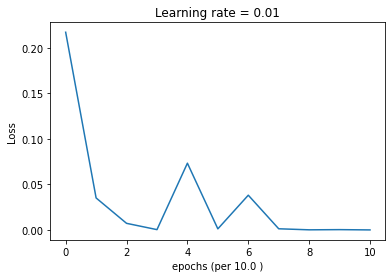

In [22]:
#defaults :
n_x = X_train.shape[1]
n_h1 = 80
n_h2 = 40
n_h3 = 20
n_y = 10
learning_rate = 0.01
batch_size = 64
num_epochs = 100

model = Neural_Net(n_x,n_h1,n_h2,n_h3,n_y).to(device)
model.apply(init_weights)
train_set = Image_Dataset(X_train,y_train)
train_loader =  DataLoader(train_set, batch_size= batch_size, shuffle = True)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()
train(model, train_loader , optimizer, criterion,num_epochs)


## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [27]:
predictions = predict(model,X_test)
accuracy(predictions,y_test)
final_model = model

Accuracy : 97.31111111111112 %


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_2.pt``` model-weights file to the repository.

In [28]:
from google.colab import files
torch.save(final_model, 'ass_2.pt')
files.download('ass_2.pt') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check if it got saved right!

In [31]:
# load the model, use predict function
model = torch.load('/content/ass_2.pt')
accuracy(predict(model,X_test),y_test)

Accuracy : 97.31111111111112 %
